In [8]:
# using DBSCAN this time -- left turns
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


In [9]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df = pd.read_csv(root / "data" / "processed" / "ios" / "state1_clean.csv", header=0)
df.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,eventSpeedChange
0,1,ios_turns.csv,4.0,8.553064,5.321719,0.014196,2.0,5.384603,8.536157,9.551594,0.608627,17.503620,93.844490,5.143511,1.015437
1,1,ios_turns.csv,4.0,9.360758,4.884875,0.012575,2.0,5.895552,9.034532,10.596797,0.546008,7.615370,37.502575,21.282076,1.562265
2,1,ios_turns.csv,5.0,10.681455,8.657750,0.021795,2.0,5.291993,11.082506,10.390737,1.024676,6.722845,58.471710,61.868423,-0.691769
3,1,ios_turns.csv,5.0,10.399240,7.823751,0.016130,2.0,4.910240,15.013917,8.630282,0.984073,12.015339,94.482200,11.925367,-6.383635
4,1,ios_turns.csv,4.0,8.345368,7.148625,0.017785,2.0,4.965302,6.963474,9.905923,0.675187,11.460243,82.380120,8.483684,2.942449


In [10]:
df.drop(columns=['source_file'], inplace=True)

df = df[(df['eventType'] == 5)]
sub_df = df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])
print(df.shape)
print(df.columns.to_list())
df.head()

(27000, 14)
['is_ios', 'eventType', 'eventSampleSpeed', 'eventDurationSeconds', 'eventMilesDriven', 'eventSensorDetectionMthd', 'eventGPSSignalStrength', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'eventSpeedChange']


,is_ios,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,eventSpeedChange
2,1,5.0,10.681455,8.657750,0.021795,2.0,5.291993,11.082506,10.390737,1.024676,6.722845,58.471710,61.868423,-0.691769
3,1,5.0,10.399240,7.823751,0.016130,2.0,4.910240,15.013917,8.630282,0.984073,12.015339,94.482200,11.925367,-6.383635
5,1,5.0,7.731082,3.971344,0.012633,0.0,4.916821,4.353902,11.944463,2.159336,10.689500,42.876198,20.782955,7.590561
6,1,5.0,8.500545,0.953109,0.005900,0.0,5.168463,8.050091,8.950999,0.690670,11.296734,11.215650,11.117670,0.900908
10,1,5.0,13.368441,5.555750,0.018427,2.0,4.736476,17.140728,13.330889,1.578454,17.069971,95.518770,10.128365,-3.809839


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df)   # or your features df

In [13]:
eps_values = np.linspace(0.1, 2.0, 20)
min_samples_values = range(10, 80, 5)

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_

        # Compute cluster metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels)

        if n_clusters < 2 and noise_pct > 0.1:
            sil = np.nan
        else:
            sil = silhouette_score(X_scaled, labels)

        results.append({
            "eps": eps,
            "min_samples": ms,
            "silhouette": sil,
            "n_clusters": n_clusters,
            "noise_pct": noise_pct
        })
results_df = pd.DataFrame(results)

sil_pivot = results_df.pivot(index="min_samples", columns="eps", values="silhouette")
noise_pivot = results_df.pivot(index="min_samples", columns="eps", values="noise_pct")
clusters_pivot = results_df.pivot(index="min_samples", columns="eps", values="n_clusters")

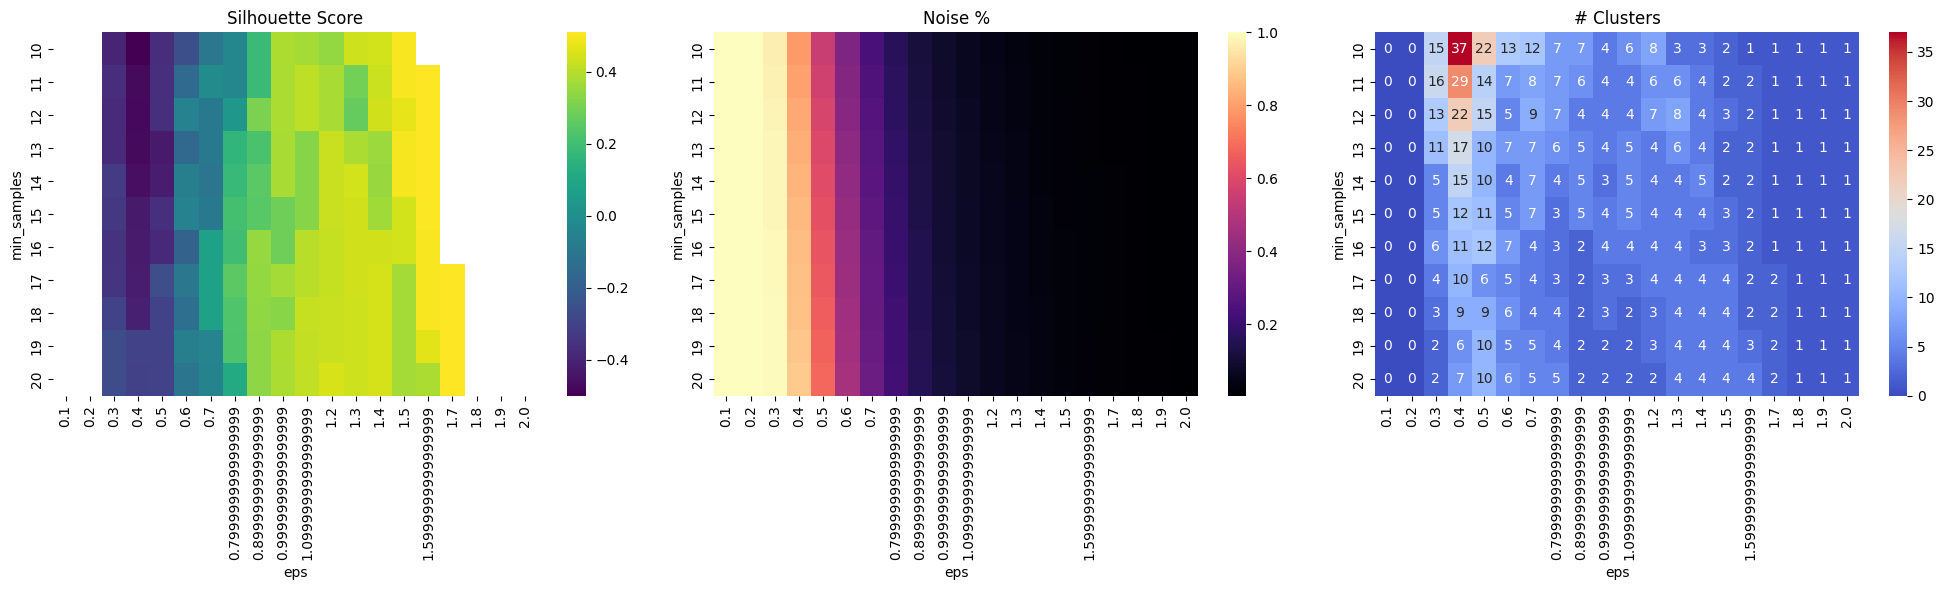

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(
    sil_pivot,
    ax=axes[0],
    cmap="viridis",
    cbar=True,
    annot=False
)
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("eps")
axes[0].set_ylabel("min_samples")

sns.heatmap(
    noise_pivot,
    ax=axes[1],
    cmap="magma",
    cbar=True,
    annot=False
)
axes[1].set_title("Noise %")
axes[1].set_xlabel("eps")
axes[1].set_ylabel("min_samples")

sns.heatmap(
    clusters_pivot,
    ax=axes[2],
    cmap="coolwarm",
    cbar=True,
    annot=True,  # number of clusters is usually small, so annotation helps
    fmt=".0f"
)
axes[2].set_title("# Clusters")
axes[2].set_xlabel("eps")
axes[2].set_ylabel("min_samples")

plt.tight_layout()
plt.show()